In [1]:
import geopandas as gpd
import os
import rasterio
import rasterio.mask
from pathlib import Path
from rasterio.plot import show
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import pandas as pd
from pystac_client import Client  
from osgeo import gdal
from tqdm import tqdm
import numpy as np
from shapely.geometry import shape

In [2]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'


def get_hls_metadata(hls_id: str):
    api = Client.open(f'{STAC_URL}/LPCLOUD/')
    hls_collections = ['HLSL30.v2.0', 'HLSS30.v2.0']

    search_params = {"collections": hls_collections,
                     "ids": [hls_id],
                     "max_items": 100}
    search_hls = api.search(**search_params)
    resp = search_hls.get_all_items()

    data = list(resp)
    if len(data) > 1:
        raise ValueError('Multiple DSWx Products for current query')
    if len(data) == 0:
        raise ValueError('No matches!')
    return data[0].to_dict()

def get_hls_date(hls_id: str):
    metadata = get_hls_metadata(hls_id)
    datetime = metadata['properties']['datetime']
    date = datetime.split('T')[0]
    return date


def get_hls_urls(hls_id: str) -> dict:
    metadata = get_hls_metadata(hls_id)
    image_urls_dict = {band: metadata['assets'][band]['href'] 
                       for band in ['B01','B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'Fmask']}
    return image_urls_dict


# Get HLS

In [3]:
HLS_ID = 'HLS.L30.T14RNV.2022003T170902.v2.0'

In [4]:
hls_url_dict = get_hls_urls(HLS_ID)
hls_url_dict

{'B01': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B01.tif',
 'B02': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B02.tif',
 'B03': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B03.tif',
 'B04': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B04.tif',
 'B05': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B05.tif',
 'B06': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B06.tif',
 'B07': 'https://data.lpdaac

# HLS Imagery

First, make sure you have logged into [Earthdata Login](https://urs.earthdata.nasa.gov/) (it will store cookies in ~/cookies.txt). Below, I copied code from this [link](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/) in section 4. It seems to work.

In [5]:
# GDAL configs used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','FALSE')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

In [6]:
def read_one(url):
    with rasterio.open(url) as ds:
        p = ds.profile
        X = ds.read(1)
    return X, p


B2, p = read_one(hls_url_dict['B02'])

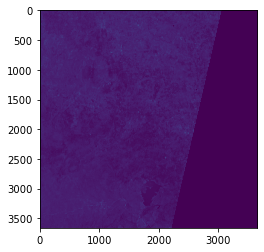

In [7]:
plt.imshow(B2, vmin=0)

# Cloud Mask and Coverage

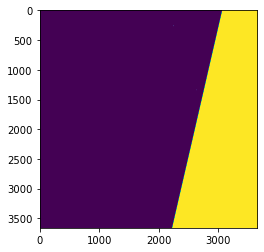

In [8]:
nodata_mask = (B2 == p['nodata'])
plt.imshow(nodata_mask)

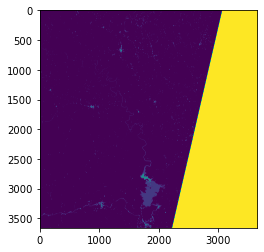

In [9]:
fmask, _ = read_one(hls_url_dict['Fmask'])

plt.imshow(fmask)

In [10]:
m, n = fmask.shape
fmask_bits = np.unpackbits(fmask)
fmask_bits = fmask_bits.reshape((m, n, 8))
fmask_bits.shape

(3660, 3660, 8)

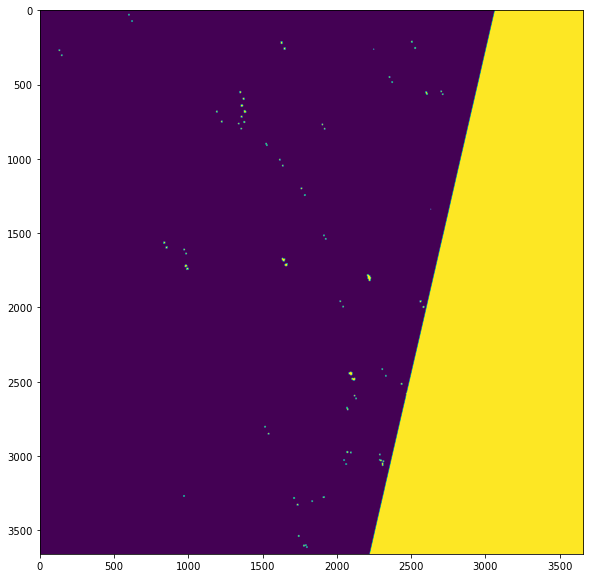

In [11]:
plt.figure(figsize=(10, 10))
fmask_clouds = fmask_bits[..., -2] | fmask_bits[..., -4] 
plt.imshow(fmask_clouds)

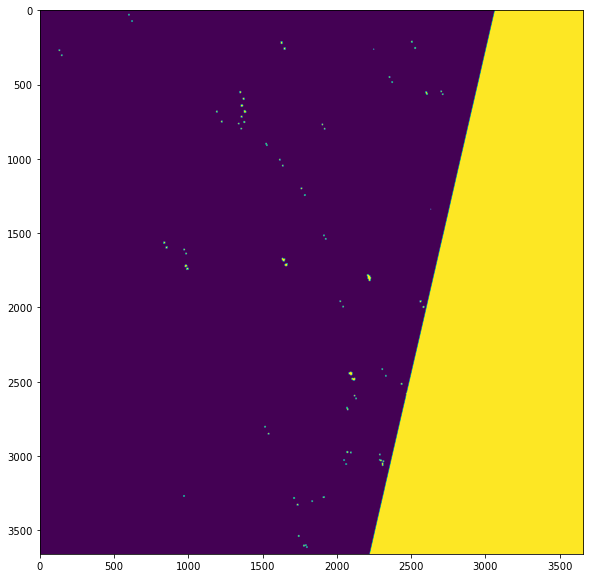

In [12]:
plt.figure(figsize=(10, 10))
fmask_clouds_2 = fmask_bits[..., -2] | fmask_bits[..., -4] 
plt.imshow(fmask_clouds_2)

In [13]:
percent_clouds = (fmask_clouds[~nodata_mask].sum()) / ((~nodata_mask).sum())
percent_clouds

0.0010154256472535976

In [14]:
p_fmask = p.copy()
p_fmask['dtype'] = np.uint8
p_fmask['nodata'] = None
with rasterio.open(f'fmask_selection_{HLS_ID}.tif', 'w', **p_fmask) as ds:
    ds.write(fmask_clouds.astype('uint8'), 1)

In [15]:
p_fmask = p.copy()
p_fmask['dtype'] = np.uint8
p_fmask['nodata'] = None
with rasterio.open(f'fmask_selection_{HLS_ID}_2.tif', 'w', **p_fmask) as ds:
    ds.write(fmask_clouds.astype('uint8'), 1)